# Generic NN trainer

In [1]:
import sys

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")

%load_ext lab_black

sys.path.append("/Users/renero/Documents/SideProjects/trader/src")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/predictor")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/utils")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/indicators")


from cs_dictionary import CSDictionary
import networks
from strings import print_bin_predictions_match
from ticks import Ticks
from utils.plots import plot_marks

## Setup the generic parameters for the trainer

In [2]:
argv = [
    "",
    "-c",
    "../src/predictor/params.eurusd.yaml",
    "-f",
    "../data/EURUSD/EURUSD_2018_2020.csv",
    "--window",
    "14",
    "--epochs",
    "200",
    "train",
]
params = CSDictionary(args=argv)

2020-10-07 12:29:52 - INFO  - CSDictionary:__init__           - Using configuration parameters from: ../src/predictor/params.eurusd.yaml


In [3]:
ticks = Ticks(params, params.input_file).scale()
ticks.append_indicator(["trend", "median_filter", "change"])
ticks.append_indicator("gmf", monotonic_window=7, mf_window=3, sigma=5)
ticks.append_indicator("gmf_mono", monotonic_window=7, mf_window=3, sigma=5)
ticks.append_indicator("trend", column_name="gmf")
ticks.data.head()

[Determinism: Random seeds reset]


,open,high,low,close,close_trend,med_filter,change,returns,gmf,gmf_mono,gmf_trend
Datetime,,,,,,,,,,,
2018-01-01,1.2274,1.1598,1.2794,1.2442,1.0,1.2423,0.0000,0.000000,0.001247,0.0,1.0
2018-01-02,1.2292,1.2731,1.2922,1.3358,1.0,1.2442,0.0916,0.073622,0.001905,0.0,1.0
2018-01-03,1.3218,1.2430,1.2794,1.2423,0.0,1.2753,-0.0935,-0.069996,0.003268,0.0,1.0
2018-01-04,1.2292,1.2873,1.2849,1.3449,1.0,1.2918,0.1026,0.082589,0.005403,0.0,1.0
2018-01-05,1.3309,1.2767,1.3160,1.2753,0.0,1.2753,-0.0696,-0.051751,0.008347,0.0,1.0


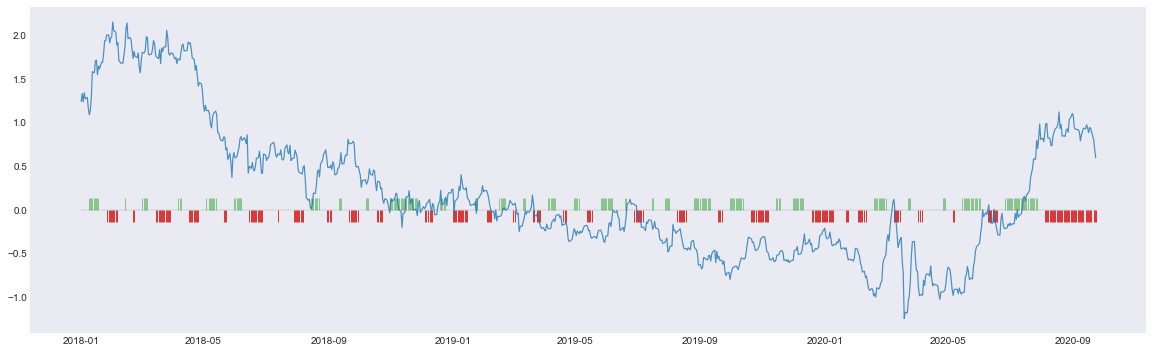

In [4]:
plot_marks(data=ticks.data, signal="close", marks="gmf_mono", dark=True)

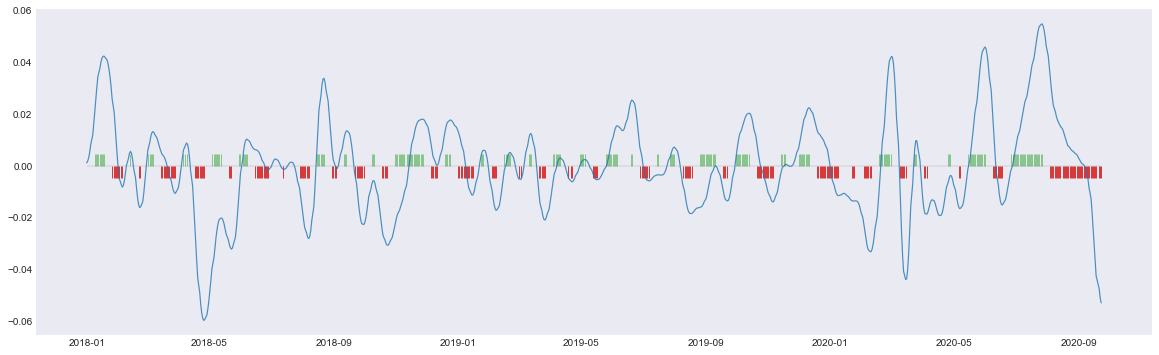

In [5]:
plot_marks(data=ticks.data, signal="gmf", marks="gmf_mono", dark=True)

## [Helper functions wrapping up common stuff]

In [6]:
def read_ticks():
    global params

    ticks = Ticks(params, params.input_file).scale()
    ticks.append_indicator(["trend", "median_filter", "change"])
    ticks.append_indicator("gmf", monotonic_window=7, mf_window=3, sigma=5)
    ticks.append_indicator("gmf_mono", monotonic_window=7, mf_window=3, sigma=5)
    ticks.append_indicator("trend", column_name="gmf")
    return ticks


def run(X_train, y_train, X_test, y_test, experiment, network, layers, binary=False):
    global params

    method = getattr(networks, network)
    nn = method(params, n_layers=layers, binary=binary)
    nn.start_training(X_train, y_train, experiment)
    yhat, acc = nn.evaluate(X_test, y_test)
    nn.end_experiment()
    return nn, yhat, acc


def split_and_run(window_size, epochs, network, layers, binary):
    global params

    ticks = read_ticks()
    params.window_size = window_size
    params.epochs = epochs
    X_train, y_train, X_test, y_test = ticks.prepare_for_training(
        predict="gmf_trend", train_columns=["gmf"]
    )
    nn, yhat, acc = run(
        X_train, y_train, X_test, y_test, "Reproducibility", network, layers, binary
    )
    del (X_train, y_train, X_test, y_test, ticks)
    return nn, yhat, acc

# Train a network to predict CLOSE with GMF, MONOTONIC SIGN and GMF TREND

In [7]:
ticks = read_ticks()
params.epochs = 79
X_train_close, y_train_close, X_test_close, y_test_close = ticks.prepare_for_training(
    predict="close_trend", train_columns=["gmf", "gmf_mono", "gmf_trend"]
)
nn1, yhat_close_trend, acc = run(
    X_train_close,
    y_train_close,
    X_test_close,
    y_test_close,
    experiment="WoW",
    network="lstm",
    layers=1,
    binary=True,
)
print_bin_predictions_match(y_test_close, yhat_close_trend)

[Determinism: Random seeds reset]
[Determinism: Random seeds reset]
2020-10-07 12:29:53 - INFO  - lstm:_build_model               - NN lstm_1layers created
2020-10-07 12:29:53 - INFO  - lstm:start_training             - Training for 79 epochs...
Epoch 079/079 - Acc:0.71 (↑0.72/↓0.53) - Val:0.64 (↑0.72/↓0.58) | [====================]
3/3 [==============================] - 0s 1ms/step - loss: 0.7688 - accuracy: 0.5833
2020-10-07 12:30:31 - INFO  - lstm:evaluate                   - Predictions (yhat): (84, 1)
2020-10-07 12:30:31 - INFO  - lstm:evaluate                   - Accuracy: 0.58
2020-10-07 12:30:31 - INFO  - lstm:evaluate                   - Trend acc.: 0.60

00 | 0 | 0.69 | 0 | 0.44 | 0 | 0.72 | 1 | 0.06 | 1 | 0.16 | 1 | 0.14 | 0 | 0.74 | 0 | 0.57 | 0 | 0.10 | 
09 | 1 | 0.77 | 1 | 0.62 | 0 | 0.81 | 1 | 0.83 | 0 | 0.70 | 1 | 0.47 | 1 | 0.63 | 1 | 0.73 | 0 | 0.72 | 
18 | 1 | 0.68 | 0 | 0.64 | 1 | 0.64 | 1 | 0.66 | 1 | 0.62 | 1 | 0.63 | 1 | 0.63 | 0 | 0.64 | 1 | 0.65 | 
27 | 1 | 0.6

In [8]:
yhat_close_trend, acc_close_trend = nn1.evaluate(X_train_close, y_train_close)

24/24 [==============================] - 0s 1ms/step - loss: 0.5571 - accuracy: 0.7183
2020-10-07 12:30:31 - INFO  - lstm:evaluate                   - Predictions (yhat): (756, 1)
2020-10-07 12:30:31 - INFO  - lstm:evaluate                   - Accuracy: 0.72
2020-10-07 12:30:31 - INFO  - lstm:evaluate                   - Trend acc.: 0.72


# Train another network to predict GMF TREND with GMF and MONOTONIC SIGN

In [9]:
ticks = read_ticks()
params.epochs = 100
X_train_gmf, y_train_gmf, X_test_gmf, y_test_gmf = ticks.prepare_for_training(
    predict="gmf_trend", train_columns=["gmf", "gmf_mono"]
)
nn2, yhat_gmf_trend, acc = run(
    X_train_gmf,
    y_train_gmf,
    X_test_gmf,
    y_test_gmf,
    experiment="WoW",
    network="lstm",
    layers=1,
    binary=True,
)
print_bin_predictions_match(y_test_gmf, yhat_gmf_trend)

[Determinism: Random seeds reset]
[Determinism: Random seeds reset]
2020-10-07 12:30:31 - INFO  - lstm:_build_model               - NN lstm_1layers created
2020-10-07 12:30:31 - INFO  - lstm:start_training             - Training for 100 epochs...
Epoch 100/100 - Acc:0.91 (↑0.92/↓0.69) - Val:0.75 (↑0.89/↓0.63) | [====================]
3/3 [==============================] - 0s 1ms/step - loss: 0.2732 - accuracy: 0.9405
2020-10-07 12:31:19 - INFO  - lstm:evaluate                   - Predictions (yhat): (84, 1)
2020-10-07 12:31:19 - INFO  - lstm:evaluate                   - Accuracy: 0.94
2020-10-07 12:31:19 - INFO  - lstm:evaluate                   - Trend acc.: 0.94

00 | 0 | 0.06 | 0 | 0.14 | 1 | 0.18 | 1 | 0.99 | 1 | 1.00 | 1 | 1.00 | 1 | 1.00 | 1 | 0.70 | 1 | 0.69 | 
09 | 1 | 0.87 | 1 | 0.90 | 1 | 0.55 | 1 | 0.89 | 1 | 0.62 | 1 | 0.84 | 1 | 0.71 | 1 | 0.85 | 1 | 0.64 | 
18 | 1 | 0.74 | 1 | 0.64 | 1 | 0.64 | 1 | 0.62 | 1 | 0.62 | 1 | 0.62 | 1 | 0.62 | 1 | 0.62 | 1 | 0.62 | 
27 | 1 | 0.

In [10]:
yhat_gmf_trend, acc_gmf_trend = nn2.evaluate(X_train_gmf, y_train_gmf)

24/24 [==============================] - 0s 1ms/step - loss: 0.2890 - accuracy: 0.9101
2020-10-07 12:31:20 - INFO  - lstm:evaluate                   - Predictions (yhat): (756, 1)
2020-10-07 12:31:20 - INFO  - lstm:evaluate                   - Accuracy: 0.91
2020-10-07 12:31:20 - INFO  - lstm:evaluate                   - Trend acc.: 0.91


In [11]:
import pandas as pd

ensemble = pd.DataFrame(
    {
        "yhat_close": yhat_close_trend.reshape(-1,),
        "yhat_gmf": yhat_gmf_trend.reshape(-1,),
        "y": y_train_close.reshape(-1,).astype(int),
    }
)

In [12]:
ensemble.head()

,yhat_close,yhat_gmf,y
0,0.816025,0.617519,0
1,0.814545,0.629542,1
2,0.783705,0.604789,0
3,0.846610,0.025967,1
4,0.874096,0.001961,1


In [13]:
for i in range(80):
    print(int(y_train_close[i][0]), end="")
print()
for i in range(80):
    print(int(y_train_gmf[i][0]), end="")
print()

01011111110111000100011111010001001001101100011100001010111000100010101110011010
11000000000000000111111100000000111111111110000000000000000000111111111000000000


In [16]:
print(nn1)

LSTM (B) - 1L U=42 D=0.10 lr=0.01 [W=14 E=100 Btch=8]
